# 경쟁하면서 학습하는 GAN

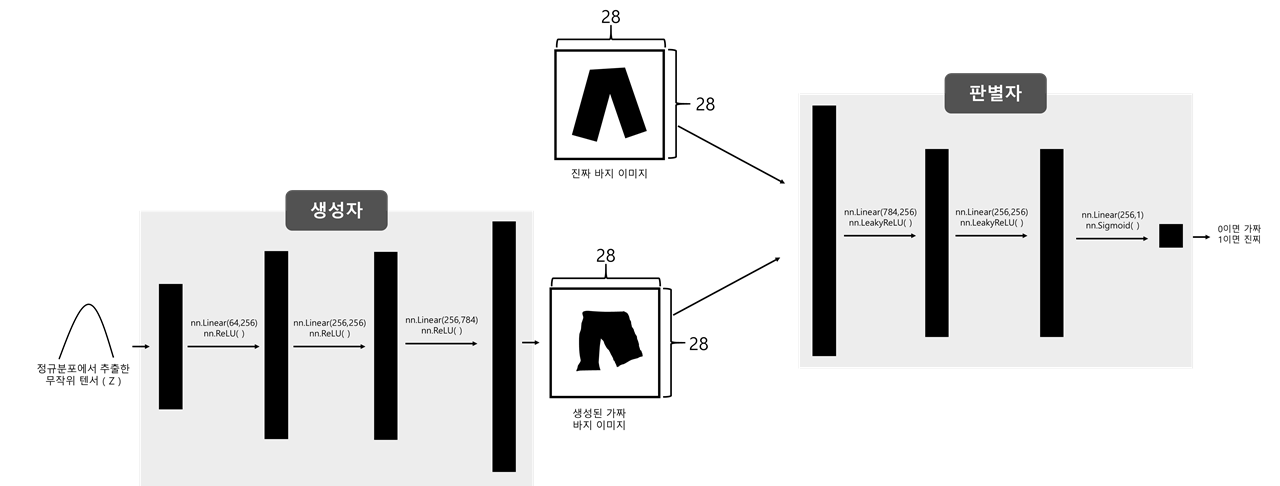

# 필요한 라이브러리 임포트

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# 하이퍼파라미터 설정

In [3]:
#하이퍼파라미터 
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 장치를 사용합니다.: ",DEVICE)


다음 장치를 사용합니다.:  cpu


# 데이터 셋

학습에 필요한 데이터셋


In [4]:
trainset = datasets.FashionMNIST('./.data',
    train= True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ]
    )
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

# 생성자와 판별자 구별

Sequential 클래스는 신경망을 이루는 각 층에서 수행할 연산들을 입력받아 차례대로 실행하는 역할을 한다.

파이토치 모듈의 __init__() 과 forward() 함수를 동시에 정의 



# 생성자

생성자 : 실제 데이터와 비슷한 가짜 데이터를 만들어 내는 신경망
정규분포로부터 뽑은 64차원의 무작위 텐서를 입력받아 행렬곱(Linear)과 활성화 함수(ReLU, Tanh) 연산을 실핸한다 
Tanh 활성하 함수는 결과값을 -1과 1 사이로 압축하는 역할을 한다. 
이 떄 결과 값은 이미지가 될 것이므로 784 차원 즉 Fashion MNIST의 이미지와 같은 차원의 텐서가 된다.

무작위 텐서를 입력하는 이유는 생성자가 실제 데이터의 분포를 배우는 것이기 때문이다.
수학적으로 그럴 듯한 가짜는 진짜의 분포를 닮는 다고 할 수 있다. 


In [5]:
# 생성자 

G = nn.Sequential(
    nn.Linear(64,256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,784),
    nn.Tanh(),
    
)


# 판별자

LeakyReLU 양의 기울기만 전달하는 ReLU와 다르게 약간의 음의 기울기도 다음 층에 전달하는 역할
이렇게 하면 판별자에서 계산된 기울기가 0이 아니라 약한 음수로 전환되며
생성자에 더 강하게 전달!
GAN에서 생성자가 학습하려면 판별자로부터 기울기를 효과적으로 전달받아야 하므로 중요하다고 할 수 있다. 

In [6]:
# 판별자

D = nn.Sequential(
    nn.Linear(784,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1),
    nn.Sigmoid()
    )

# GAN 학습 구현 

to() 함수로 모델을 학습에 쓰일 장치로 보낸다
생성자와 판별자 학습에 쓰일 오차 함수와 최적화 알고리즘고 각갖 정의한다.

레이블이 가짜,진짜 2가지 뿐이므로 오차를 구하는 데 이진 교차 엔트로피를 사용하고 
Adam 최적화 함수를 이용해 학습한다.

In [7]:
# 모델의 가중치를 지정한 장치로 보내기 

D = D.to(DEVICE)
G = G.to(DEVICE)


#이진 교차 엔트로피 오차 함수와 
# 생성자와 판별자를 최적화할 Adam 모듈

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(),lr = 0.0002)
g_optimizer = optim.Adam(G.parameters(),lr = 0.0002)

# GAN 학습

생성자가 만든 데이터는 가짜라나느 레이블을 부여받고 진짜 데이터와 함께 신경망에 입력

real_labels 텐서는 ones() 함수를 불러 1로만 이루어진 텐서를 만들고 
fake_labels 텐서는 zeros() 함수를 불로 0으로만 이루어잔 텐서를 만든다.

판별자는 이미지를 보고 진짜를 구분하는 능력을 학습해야 한다.
그러기 위해서 실제 이미지를 판별자 신경망에 입력해 얻어낸 결괏값과
진짜 레이블 사이의 오차를 계산해야 한다.

생성자는 정규분포로부터 생성한 무작위 텐서를 입력받아 
실제 이미지와 같은 차원의 텐서를 배출해야 한다.

판별자가 가짜 이미지를 가짜로 인식하는 지 아랑보기 위해서 
fake_images를 판별자에 입력한다.
결괏값과 가짜 레이블 사이의 오차를 계산한다. 

전체 오차  = 진짜 이미지의 오차 + 가짜 이미지의 오차 

다음으로 역전파 알고리즘과 경사하강법을 통해서 
판별자 신경마을 학습한다.

학습 시 zero _ grad() 함수로 생성자와 판별자의 기울기를 초기화한다.


In [ ]:
# GAN을 학습시키는 반복문 
total_stap = len(train_loader)
for epoch in range(EPOCHS):
    for  i,(images,_) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        #진짜와 가짜 레이블 생성 
        real_labels = torch.ones(BATCH_SIZE,1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE,1).to(DEVICE)
        
        #판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
        outputs = D(images) # 실제 이미지를 신경망에 입력해서 결과를 얻음
        d_loss_real = criterion(outputs, real_labels) # 오차 계산 
        real_scores = outputs  # 실제 이미지의 오차값
        
        #무작위 텐서로 가짜 이미지 생성 
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z) #생성자에 z를 입력해 가짜 이미지 생성 
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        output = D(fake_images)
        d_loss_fake = criterion(output, fake_labels)
        fake_scores = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자으 오차 계산
        d_loss = d_loss_real + d_loss_fake  
        
        #역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자 판별자를 속였는지에 대한 오차 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion ( outputs, real_labels )
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행 
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('이폭 [{}/{}] d_loss:{:.4f} g_losss:{:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
         .format(epoch, EPOCHS, d_loss.item(), g_loss.item(),
                real_scores.mean().item(), fake_scores.mean().item()))
    

이폭 [0/500] d_loss:0.1078 g_losss:3.9686 D(x):0.96 D(G(z)):0.96
이폭 [1/500] d_loss:0.0553 g_losss:5.6599 D(x):0.97 D(G(z)):0.97
이폭 [2/500] d_loss:0.0121 g_losss:7.0143 D(x):1.00 D(G(z)):1.00
이폭 [3/500] d_loss:0.0640 g_losss:6.5198 D(x):0.97 D(G(z)):0.97
이폭 [4/500] d_loss:0.1011 g_losss:5.4351 D(x):0.97 D(G(z)):0.97
이폭 [5/500] d_loss:0.2048 g_losss:4.5840 D(x):0.94 D(G(z)):0.94
이폭 [6/500] d_loss:0.1888 g_losss:5.1344 D(x):0.96 D(G(z)):0.96
이폭 [7/500] d_loss:0.1294 g_losss:5.7555 D(x):0.95 D(G(z)):0.95
이폭 [8/500] d_loss:0.2756 g_losss:4.5333 D(x):0.92 D(G(z)):0.92
이폭 [9/500] d_loss:0.2367 g_losss:5.7002 D(x):0.92 D(G(z)):0.92
이폭 [10/500] d_loss:0.1258 g_losss:6.8920 D(x):0.95 D(G(z)):0.95
이폭 [11/500] d_loss:0.2016 g_losss:4.4330 D(x):0.92 D(G(z)):0.92
이폭 [12/500] d_loss:0.2203 g_losss:4.6275 D(x):0.94 D(G(z)):0.94
이폭 [13/500] d_loss:0.2335 g_losss:4.6202 D(x):0.91 D(G(z)):0.91
이폭 [14/500] d_loss:0.2718 g_losss:3.9992 D(x):0.92 D(G(z)):0.92
이폭 [15/500] d_loss:0.2965 g_losss:4.8530 D(x):0.91

# 결과물 시각화

In [ ]:
# 생성자가 만든 이밎 시각화하기
z = torch.randn(BATCH_SIZE,64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28,28))
    plt.show(fake_images_img, cmap = 'gray')
    plt.show()